In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

In [3]:
class conv2DNet(nn.Module):
    
    def __init__(self, Nchannels, Nsamples, output_units):
        """Initializes neural network with 3 convolutional layers and 1 fully-connected layer.
        
        Args:
            - Nchannels (int): number of EEG channels
            - Nsamples (int): number of time points in each EEG signal
            - output_units (int): number of output units, e.g. 1 for training with loss torch.nn.BCELoss or 2 with 
            loss torch.nn.CrossEntropyLoss            
            
            """
        super(conv2DNet, self).__init__()
        
        # Layer 1
        
        channelsConv1a = 7
        channelsConv1b = 15
        
        self.conv1a = nn.Conv2d(1, channelsConv1a, (5, 5), padding=2)  # does not change size if combined with above padding
        self.batchnorm1a = nn.BatchNorm2d(channelsConv1a)
        self.conv1b = nn.Conv2d(channelsConv1a, channelsConv1b, (5, 5), padding=2)  # does not change size if combined with above padding
        self.batchnorm1b = nn.BatchNorm2d(channelsConv1b)
        self.pooling1 = nn.MaxPool2d((2, 2), stride = 2) 

        # Layer 2
        channelsConv2a = 31 
        channelsConv2b = 63
        
        self.conv2a = nn.Conv2d(channelsConv1b, channelsConv2a, (3, 3), padding=1)  # does not change size if combined with above padding
        self.batchnorm2a = nn.BatchNorm2d(channelsConv2a)
        self.conv2b = nn.Conv2d(channelsConv2a, channelsConv2b, (3, 3), padding=1)  # does not change size if combined with above padding
        self.batchnorm2b = nn.BatchNorm2d(channelsConv2b)
        self.pooling2 = nn.MaxPool2d((2, 2), stride = 2)  

        # Layer 3
        channelsConv3a = 125 
        channelsConv3b = 251
        
        self.conv3a = nn.Conv2d(channelsConv2b, channelsConv3a, (3, 3), padding=1)  # does not change size if combined with above padding
        self.batchnorm3a = nn.BatchNorm2d(channelsConv3a)
        self.conv3b = nn.Conv2d(channelsConv3a, channelsConv3b, (3, 3), padding=1)  # does not change size if combined with above padding
        self.batchnorm3b = nn.BatchNorm2d(channelsConv3b)
        self.pooling3 = nn.MaxPool2d((2, 2), stride = 2) 
        
        # FC Layer
        fc_inputs = 251 * 4 * 8
        
        self.fc1 = nn.Linear(fc_inputs, int(fc_inputs/4))
        self.fc2 = nn.Linear(int(fc_inputs/4), 251)
        self.fc3 = nn.Linear(251, output_units)

        
    def forward(self, x):
        """Applies forward pass consisting of 3 convolutional layers followed by a fully-connected linear layer.
        
        Args:
            - x (torch.autograd.Variable): the input batch. It has dimension batch_size x Nchannel x Nsamples x 1,
            where Nchannel is the number of EEG channels and Nsamples the number of time points.
        
        Returns:
            - (torch.autograd.Variable) of size either batch_size x output_units   
        
        """
    
        # Layer 1
        x = F.relu(self.conv1a(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm1a(x)
        x = F.relu(self.conv1b(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm1b(x)
        x = self.pooling1(x)
        x = F.dropout2d(x, 0.3)

        # Layer 2
        x = F.relu(self.conv2a(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm2a(x)
        x = F.relu(self.conv2b(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm2b(x)
        x = self.pooling2(x)
        x = F.dropout2d(x, 0.3)

        # Layer 3
        x = F.relu(self.conv3a(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm3a(x)
        x = F.relu(self.conv3b(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm3b(x)
        x = self.pooling3(x)
        x = F.dropout2d(x, 0.3)
        
        #print(x.shape)
        
        # Fully-connected Layer
        x = x.view(-1, 251*4*8)  # bsize x (l3_channels*floor(l1_channels/4)*floor(Nsamples/16))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = F.sigmoid(self.fc3(x))            # bisze x self.fc1.out_features  
        
        if self.fc3.out_features == 1:
            x = x.view(-1)                     # bsize (1D if 1 output unit)
        
        #print(x.shape)
        return x

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = data_input.size(0)
    model.eval()
    
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train_100(train_input_1000, train_target_1000, False, False)
preprocessed_input_test = preprocessing_test_100(test_input_100, False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = test_target_100
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

print('Ntrain', Ntrain)
print('Ntest', Ntest)
print('Nvalidation', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), volatile=True )
test_input = Variable(preprocessed_input_test.view(Ntest, 1, Nchannels, Nsamples_100), volatile=True )

train (3000, 28, 50)
test (100, 28, 50)
validation (160, 28, 50)
Ntrain 3000
Ntest 100
Nvalidation 160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
else:
    train_target = Variable(preprocessed_input_train_target.float()) # convert to float
    validation_target = Variable(preprocessed_input_validation_target.float(), volatile=True ) # convert to float
    test_target = Variable(test_target_100.float(), volatile=True )
    Noutputs = 1
        
model = conv2DNet(Nchannels, Nsamples_100, Noutputs)

#optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.90, nesterov=False)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adagrad(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.ASGD(model.parameters())
#optimizer = optim.RMSprop(model.parameters())
#optimizer = optim.Rprop(model.parameters())

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 10
Nrep = 1

train_errors = torch.Tensor(Nepochs).zero_()
test_errors = torch.Tensor(Nepochs).zero_()
validation_errors = torch.Tensor(Nepochs).zero_()

ep_loss = torch.Tensor(Nepochs).zero_()

for i_rep in range(Nrep):
    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_ep])
        
        train_errors[i_ep] = nb_train_errs
        test_errors[i_ep] = nb_test_errs
        validation_errors[i_ep] = nb_validation_errs

Epoch Number :  0
	 Training accuracy:  76.33333333333333
	 Validation accuracy  62.5
	 Test accuracy  59.0
	 Epoch Loss  124.68476867675781
Epoch Number :  1
	 Training accuracy:  83.63333333333334
	 Validation accuracy  75.625
	 Test accuracy  64.0
	 Epoch Loss  60.792205810546875
Epoch Number :  2
	 Training accuracy:  92.76666666666667
	 Validation accuracy  54.375
	 Test accuracy  62.0
	 Epoch Loss  24.641550064086914
Epoch Number :  3
	 Training accuracy:  93.5
	 Validation accuracy  71.875
	 Test accuracy  64.0
	 Epoch Loss  16.20610809326172
Epoch Number :  4
	 Training accuracy:  94.43333333333334
	 Validation accuracy  70.0
	 Test accuracy  65.0
	 Epoch Loss  11.652838706970215
Epoch Number :  5
	 Training accuracy:  97.3
	 Validation accuracy  75.0
	 Test accuracy  63.0
	 Epoch Loss  2.290235996246338
Epoch Number :  6
	 Training accuracy:  97.33333333333333
	 Validation accuracy  75.0
	 Test accuracy  64.0
	 Epoch Loss  0.003264885162934661
Epoch Number :  7
	 Training accu

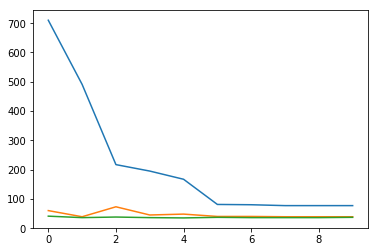

In [7]:
plt.plot(np.array(train_errors))
plt.plot(np.array(validation_errors))
plt.plot(np.array(test_errors))
plt.show()

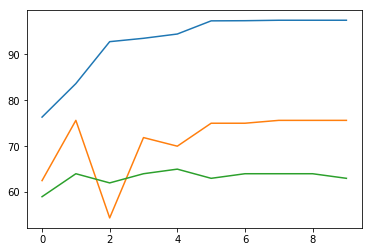

In [8]:
plt.plot(100*(Ntrain-np.array(train_errors))/Ntrain)
plt.plot(100*(Nvalidation-np.array(validation_errors))/Nvalidation)
plt.plot(100*(Ntest-np.array(test_errors))/Ntest)

plt.show()